In [1]:

# ==========================================
# Project : Predicting Customer Churn
# Strategic Retention: From Prediction to Intervention
# ==========================================

# 1. SETUP & LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# Handling Class Imbalance
from imblearn.over_sampling import SMOTE

In [2]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set visual style
sns.set(style="whitegrid")

In [5]:
# ==========================================
# 2. DATA LOADING & PREPARATION
# ==========================================

# Load the dataset (Ensure the CSV file is in the same directory)
# If using Google Colab, upload the file first.
try:
    df = pd.read_csv(r'/Users/balakrishnamupparaju/Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print("Data Loaded Successfully.")
except FileNotFoundError:
    print("ERROR: File not found. Please upload 'WA_Fn-UseC_-Telco-Customer-Churn.csv'")

Data Loaded Successfully.


In [6]:
# Data Cleaning
# 'TotalCharges' contains empty strings for new customers. Coerce to numeric (errors become NaN).
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill NaN values (which were empty strings) with 0
df['TotalCharges'].fillna(0, inplace=True)

# Convert Target 'Churn' to Binary (1 for Yes, 0 for No)
df['Churn_Binary'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Drop customerID as it is not predictive
df_clean = df.drop(['customerID'], axis=1)

In [7]:
# One-Hot Encoding for Categorical Variables
# drop_first=True avoids the dummy variable trap
df_encoded = pd.get_dummies(df_clean.drop(['Churn'], axis=1), drop_first=True)

print(f"Dataset Shape after preprocessing: {df_encoded.shape}")

Dataset Shape after preprocessing: (7043, 31)


In [8]:
# ==========================================
# 3. SPLITTING & BALANCING (SMOTE)
# ==========================================

# Define Features (X) and Target (y)
X = df_encoded.drop('Churn_Binary', axis=1)
y = df_encoded['Churn_Binary']

# Train-Test Split (75% Train, 25% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Apply SMOTE (Synthetic Minority Oversampling Technique) to Training Data ONLY
print("\nBalancing data with SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original Training Class Distribution: \n{y_train.value_counts()}")
print(f"Balanced Training Class Distribution: \n{y_train_smote.value_counts()}")


Balancing data with SMOTE...
Original Training Class Distribution: 
Churn_Binary
0    3892
1    1390
Name: count, dtype: int64
Balanced Training Class Distribution: 
Churn_Binary
1    3892
0    3892
Name: count, dtype: int64


In [9]:
# ==========================================
# 4. MODELING (Random Forest)
# ==========================================

print("\nTraining Random Forest Model...")
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_smote, y_train_smote)

# Predictions
y_pred = rf_model.predict(X_test)
y_probs = rf_model.predict_proba(X_test)[:, 1] # Probability scores for risk analysis

# Evaluation
print("\n--- Model Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Training Random Forest Model...

--- Model Performance ---
Accuracy: 0.7927314026121521

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85      1282
           1       0.60      0.71      0.65       479

    accuracy                           0.79      1761
   macro avg       0.74      0.77      0.75      1761
weighted avg       0.81      0.79      0.80      1761



In [10]:
# ==========================================
# 5. STRATEGIC ANALYSIS (Risk Quadrants)
# ==========================================

# Create a DataFrame for Analysis (Test Set + Predictions)
# We need to map the original 'MonthlyCharges' back to the test set indices
# Since X_test is already processed, we use it directly.
analysis_df = X_test.copy()
analysis_df['Churn_Probability'] = y_probs
analysis_df['Actual_Churn'] = y_test

# Define Strategy Segments
# High Value = Monthly Charges > Median ($70 approx)
# High Risk = Churn Probability > 0.5
def categorize_customer(row):
    if row['MonthlyCharges'] > 70 and row['Churn_Probability'] > 0.5:
        return 'VIP at Risk (Priority 1)'
    elif row['MonthlyCharges'] > 70 and row['Churn_Probability'] <= 0.5:
        return 'Safe VIP (Upsell Target)'
    elif row['MonthlyCharges'] <= 70 and row['Churn_Probability'] > 0.5:
        return 'Low-Value Risk (Monitor)'
    else:
        return 'Standard Customer'

analysis_df['Segment'] = analysis_df.apply(categorize_customer, axis=1)

print("\n--- Strategic Customer Segments ---")
print(analysis_df['Segment'].value_counts())


--- Strategic Customer Segments ---
Segment
Standard Customer           711
Safe VIP (Upsell Target)    484
VIP at Risk (Priority 1)    400
Low-Value Risk (Monitor)    166
Name: count, dtype: int64


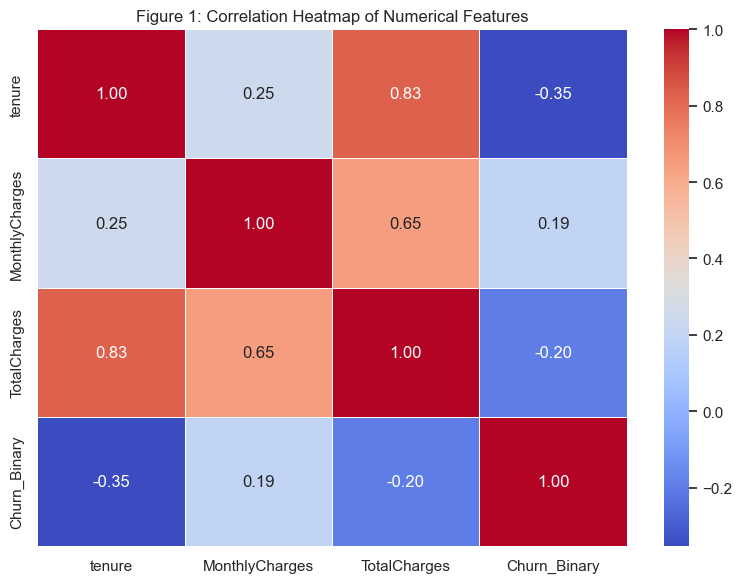

In [15]:
# ==========================================
# 6. VISUALIZATION GENERATION
# ==========================================

# FIGURE 1: Correlation Heatmap
plt.figure(figsize=(8, 6))
# Select only a few key numerical columns for clarity
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_Binary']
# Note: We use the original 'df' for this specific plot to show raw correlations
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Figure 1: Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.savefig('Figure1_Heatmap.png')
plt.show()

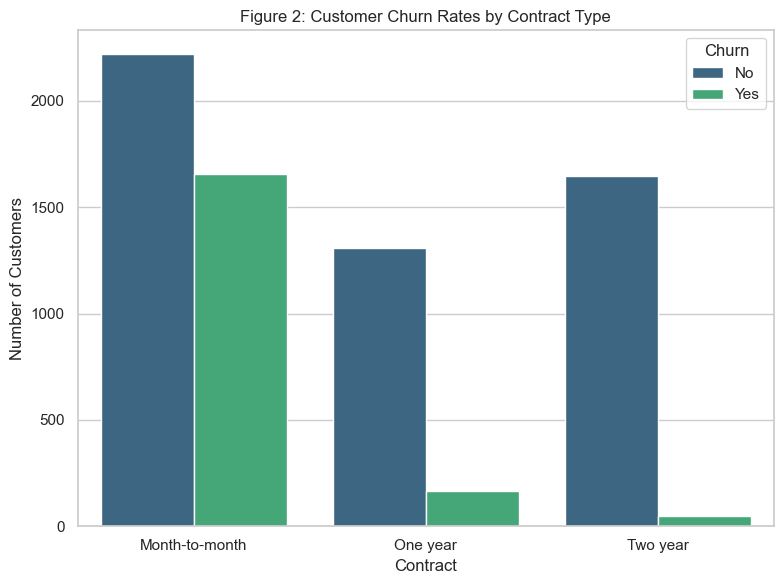

In [12]:
# FIGURE 2: Churn by Contract Type
plt.figure(figsize=(8, 6))
sns.countplot(x='Contract', hue='Churn', data=df, palette='viridis')
plt.title('Figure 2: Customer Churn Rates by Contract Type')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.savefig('Figure2_ContractChurn.png')
plt.show()

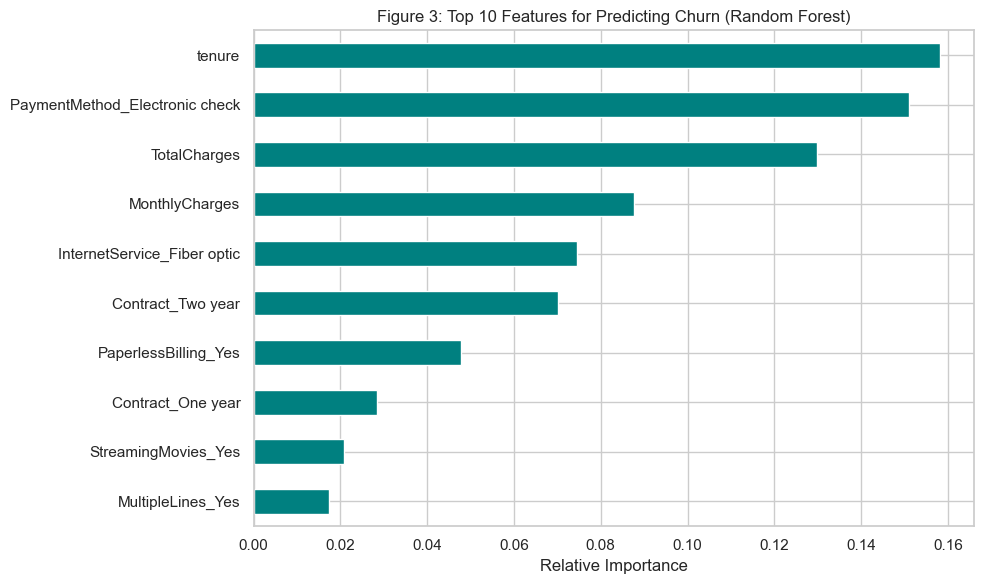

In [13]:
# FIGURE 3: Feature Importance (Random Forest)
importances = rf_model.feature_importances_
feature_names = X.columns
feat_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(10, 6))
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title('Figure 3: Top 10 Features for Predicting Churn (Random Forest)')
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis() # Highest importance at the top
plt.tight_layout()
plt.savefig('Figure3_FeatureImportance.png')
plt.show()

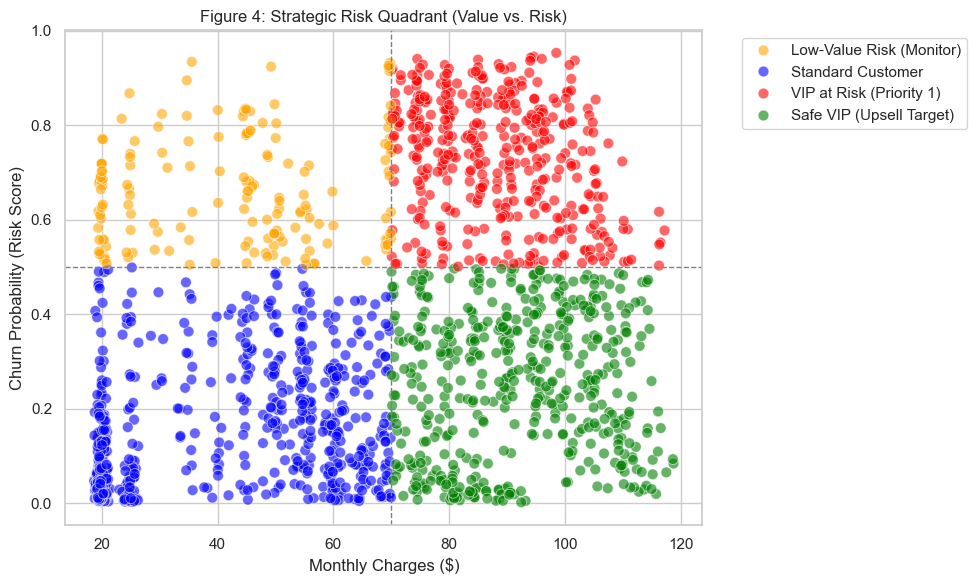


Processing Complete. All 4 Figures have been saved.


In [14]:
# FIGURE 4: Strategic Risk Quadrant
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=analysis_df, 
    x='MonthlyCharges', 
    y='Churn_Probability', 
    hue='Segment',
    palette={'VIP at Risk (Priority 1)': 'red', 
             'Safe VIP (Upsell Target)': 'green', 
             'Low-Value Risk (Monitor)': 'orange', 
             'Standard Customer': 'blue'},
    alpha=0.6,
    s=60
)
plt.axhline(y=0.5, color='grey', linestyle='--', linewidth=1) # Risk Threshold
plt.axvline(x=70, color='grey', linestyle='--', linewidth=1)  # Value Threshold
plt.title('Figure 4: Strategic Risk Quadrant (Value vs. Risk)')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Churn Probability (Risk Score)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Figure4_RiskQuadrant.png')
plt.show()

print("\nProcessing Complete. All 4 Figures have been saved.")